In [16]:
import pandas as pd
import json
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '2024InternshipData.csv'
df = pd.read_csv(file_path)

df.head()

,time_epoch,device_id,event_data,event_id
0,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
1,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
2,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
3,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
4,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",sessionFinished


### Extracting relevant fields from dataframe

In [18]:
df_expanded = pd.json_normalize(df['event_data'].apply(json.loads))
df_cleaned = pd.concat([df, df_expanded[['session_id', 'experimentGroup', 'selectedIndexes', 'eventIndex']]], axis=1)
df_cleaned.rename(columns={'experimentGroup': 'experiment_group', 'eventIndex': 'event_index'}, inplace=True)
df_cleaned = df_cleaned.dropna(subset=['experiment_group'])
df_cleaned['experiment_group'] = pd.to_numeric(df_cleaned['experiment_group'])
df_cleaned['time'] = pd.to_datetime(df['time_epoch'], unit='ms')
df_cleaned['device_id'] = df['device_id']
df_cleaned['event_id'] = df['event_id']
df_cleaned.head()

,time_epoch,device_id,event_data,event_id,session_id,experiment_group,selectedIndexes,event_index,time
0,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,None,0,2023-11-13 21:31:56.038000000
1,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,None,1,2023-11-13 21:32:01.000855713
2,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,None,2,2023-11-13 21:32:07.441097168
3,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,None,3,2023-11-13 21:32:12.546752930
4,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",sessionFinished,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,[0],4,2023-11-13 21:32:19.700576172


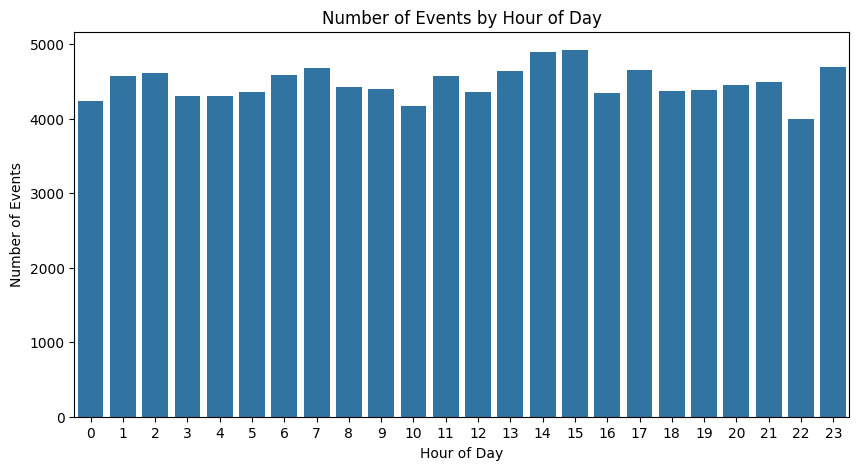

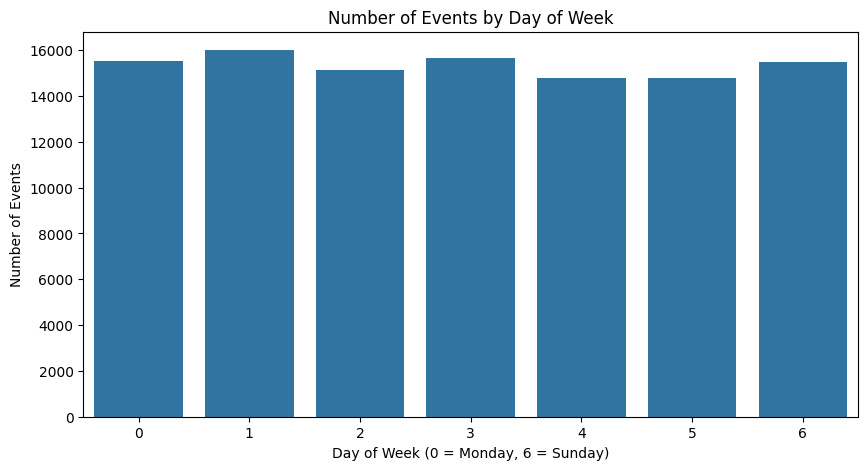

In [19]:
df_cleaned['hour'] = df_cleaned['time'].dt.hour
df_cleaned['day_of_week'] = df_cleaned['time'].dt.dayofweek

plt.figure(figsize=(10, 5))
sns.countplot(x='hour', data=df_cleaned)
plt.title('Number of Events by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='day_of_week', data=df_cleaned)
plt.title('Number of Events by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Number of Events')
plt.show()

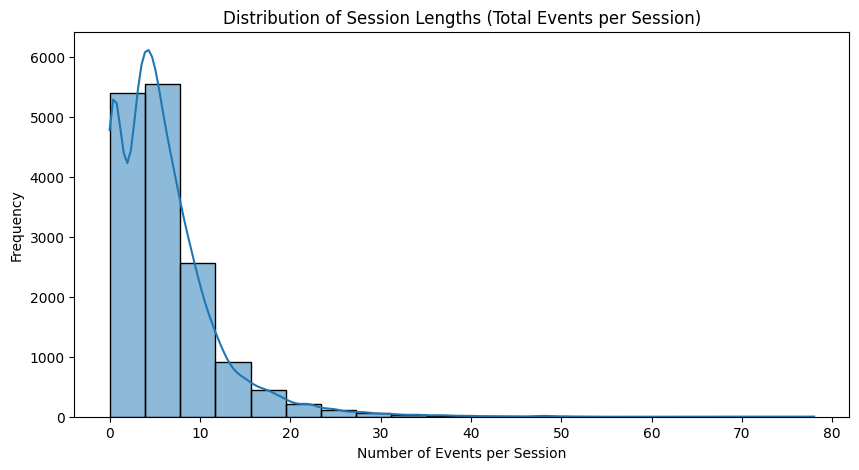

In [23]:
session_lengths = df_cleaned.groupby(['experiment_group', 'session_id'])['event_index'].max().reset_index(name='session_length')

session_lengths.head()
plt.figure(figsize=(10, 5))
sns.histplot(session_lengths['session_length'], bins=20, kde=True)
plt.title('Distribution of Session Lengths (Total Events per Session)')
plt.xlabel('Number of Events per Session')
plt.ylabel('Frequency')
plt.show()

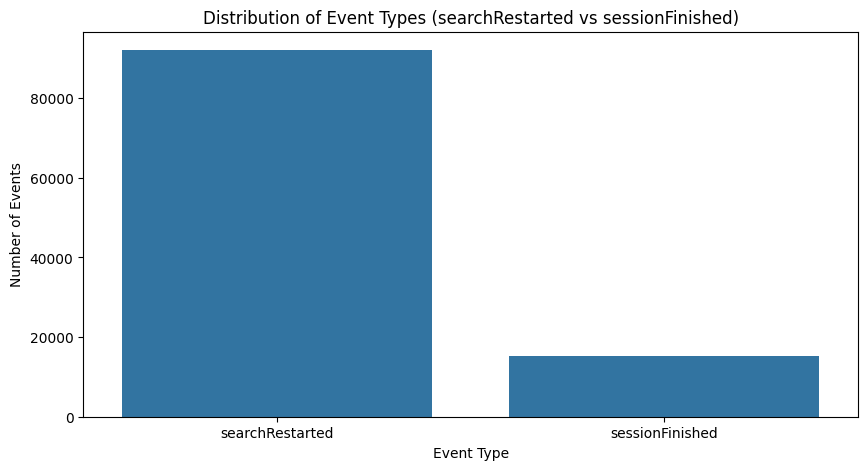

In [24]:
event_type_counts = df_cleaned['event_id'].value_counts()

plt.figure(figsize=(10, 5))
sns.countplot(x='event_id', data=df_cleaned)
plt.title('Distribution of Event Types (searchRestarted vs sessionFinished)')
plt.xlabel('Event Type')
plt.ylabel('Number of Events')
plt.show()

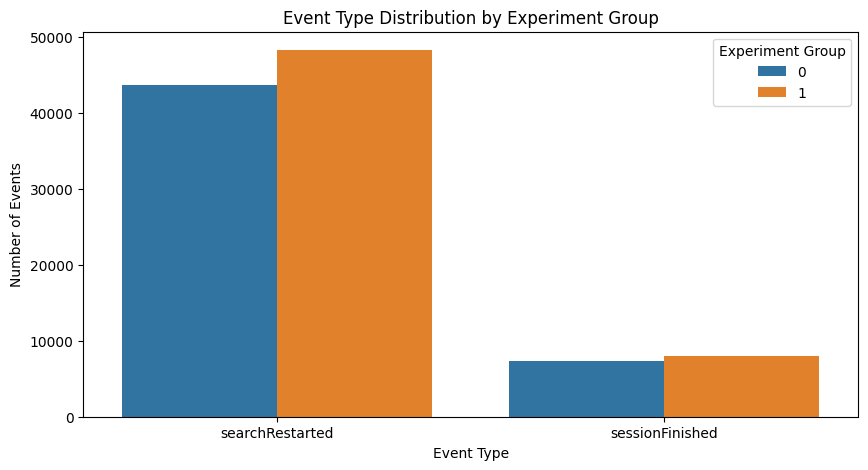

In [26]:
df_cleaned['selected_count'] = df_cleaned['selectedIndexes'].apply(lambda x: len(x) if isinstance(x, list) else 0)

plt.figure(figsize=(10, 5))
sns.countplot(x='event_id', hue='experiment_group', data=df_cleaned)
plt.title('Event Type Distribution by Experiment Group')
plt.xlabel('Event Type')
plt.ylabel('Number of Events')
plt.legend(title='Experiment Group')
plt.show()

In [28]:
def extract_search_state_features(event_data):
    try:
        data = json.loads(event_data)
        return data.get('searchStateFeatures', {})
    except (json.JSONDecodeError, TypeError):
        return {}

df_cleaned['searchStateFeatures'] = df['event_data'].apply(extract_search_state_features)

df_cleaned['searchStateFeatures'].head()

0    {'queryLength': 11}
1    {'queryLength': 12}
2    {'queryLength': 13}
3    {'queryLength': 14}
4    {'queryLength': 13}
Name: searchStateFeatures, dtype: object

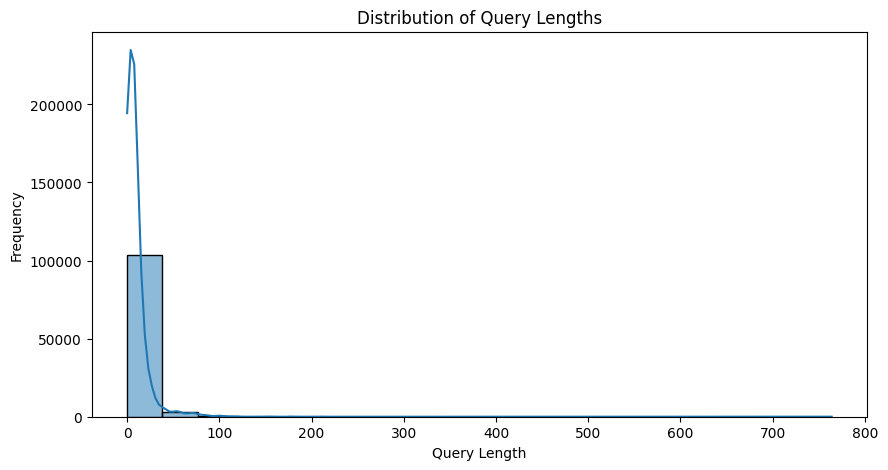

In [29]:
df_cleaned['searchStateFeatures'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else []).value_counts()

df_cleaned['queryLength'] = df_cleaned['searchStateFeatures'].apply(lambda x: x.get('queryLength') if isinstance(x, dict) else None)

plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['queryLength'].dropna(), bins=20, kde=True)
plt.title('Distribution of Query Lengths')
plt.xlabel('Query Length')
plt.ylabel('Frequency')
plt.show()

### Computing event counts and selected counts

In [6]:
session_event_counts = df_cleaned.groupby(['experiment_group', 'session_id']).size().reset_index(name='event_count')

df_cleaned['selected_count'] = df_cleaned['selectedIndexes'].apply(lambda x: len(x) if isinstance(x, list) else 0)

event_count_summary = session_event_counts.groupby('experiment_group')['event_count'].describe()
selected_summary = df_cleaned.groupby('experiment_group')['selected_count'].describe()

event_count_summary, selected_summary

(                   count      mean       std  min  25%  50%  75%   max
 experiment_group                                                      
 0                 7312.0  6.976477  5.668665  1.0  3.0  6.0  9.0  79.0
 1                 8035.0  7.010828  5.507029  1.0  4.0  6.0  9.0  59.0,
                     count      mean       std  min  25%  50%  75%  max
 experiment_group                                                      
 0                 51012.0  0.082196  0.274666  0.0  0.0  0.0  0.0  1.0
 1                 56332.0  0.080505  0.272076  0.0  0.0  0.0  0.0  1.0)

### T-Test for event counts per session

In [7]:
group_0_event_counts = session_event_counts[session_event_counts['experiment_group'] == 0]['event_count']
group_1_event_counts = session_event_counts[session_event_counts['experiment_group'] == 1]['event_count']

t_stat_event, p_value_event = stats.ttest_ind(group_0_event_counts, group_1_event_counts)

print(f"T-test for Event Counts per Session: t-statistic = {t_stat_event}, p-value = {p_value_event}")

T-test for Event Counts per Session: t-statistic = -0.3805746395574344, p-value = 0.7035241702935514


### Mann-Whitney U Test for event counts

In [8]:
u_stat_event, p_value_mann_event = stats.mannwhitneyu(group_0_event_counts, group_1_event_counts)

print(f"Mann-Whitney U Test for Event Counts: U-statistic = {u_stat_event}, p-value = {p_value_mann_event}")

Mann-Whitney U Test for Event Counts: U-statistic = 29131711.5, p-value = 0.37121958236819086


### T-Test for selected item counts per event

In [9]:
group_0_selected_counts = df_cleaned[df_cleaned['experiment_group'] == 0]['selected_count']
group_1_selected_counts = df_cleaned[df_cleaned['experiment_group'] == 1]['selected_count']

t_stat_selected, p_value_selected = stats.ttest_ind(group_0_selected_counts, group_1_selected_counts)

print(f"T-test for Selected Item Counts: t-statistic = {t_stat_selected}, p-value = {p_value_selected}")

T-test for Selected Item Counts: t-statistic = 1.0125978027519273, p-value = 0.31125459222097307


### Levene’s Test for equality of variances

In [10]:
levene_stat_event, p_value_levene_event = stats.levene(group_0_event_counts, group_1_event_counts)

levene_stat_selected, p_value_levene_selected = stats.levene(group_0_selected_counts, group_1_selected_counts)

print(f"Levene's Test for Event Count Variances: statistic = {levene_stat_event}, p-value = {p_value_levene_event}")
print(f"Levene's Test for Selected Count Variances: statistic = {levene_stat_selected}, p-value = {p_value_levene_selected}")

Levene's Test for Event Count Variances: statistic = 0.11062141240500828, p-value = 0.7394423161186603
Levene's Test for Selected Count Variances: statistic = 1.0253543101380314, p-value = 0.31125459223440577


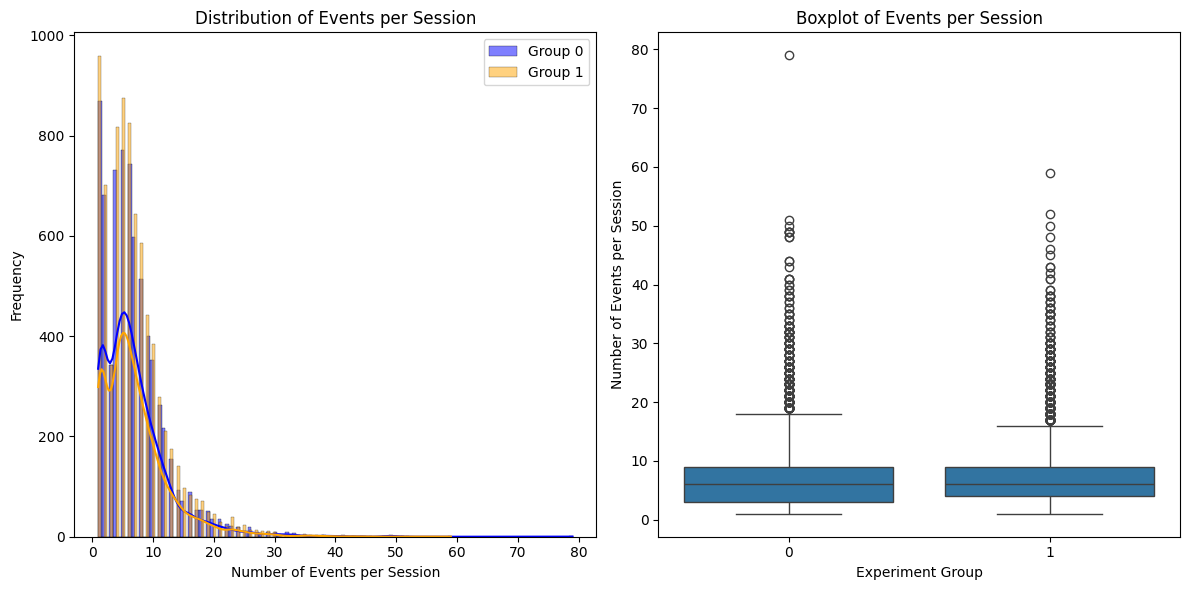

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(group_0_event_counts, label='Group 0', color='blue', kde=True)
sns.histplot(group_1_event_counts, label='Group 1', color='orange', kde=True)
plt.title('Distribution of Events per Session')
plt.xlabel('Number of Events per Session')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x='experiment_group', y='event_count', data=session_event_counts)
plt.title('Boxplot of Events per Session')
plt.xlabel('Experiment Group')
plt.ylabel('Number of Events per Session')

plt.tight_layout()
plt.show()

/var/folders/lx/mx4dyvb92_db5j93t2hv5brh0000gp/T/ipykernel_30772/3811280335.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='experiment_group', y='event_count', data=session_event_counts, palette="muted")
/var/folders/lx/mx4dyvb92_db5j93t2hv5brh0000gp/T/ipykernel_30772/3811280335.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='experiment_group', y='selected_count', data=df_cleaned, palette="muted")


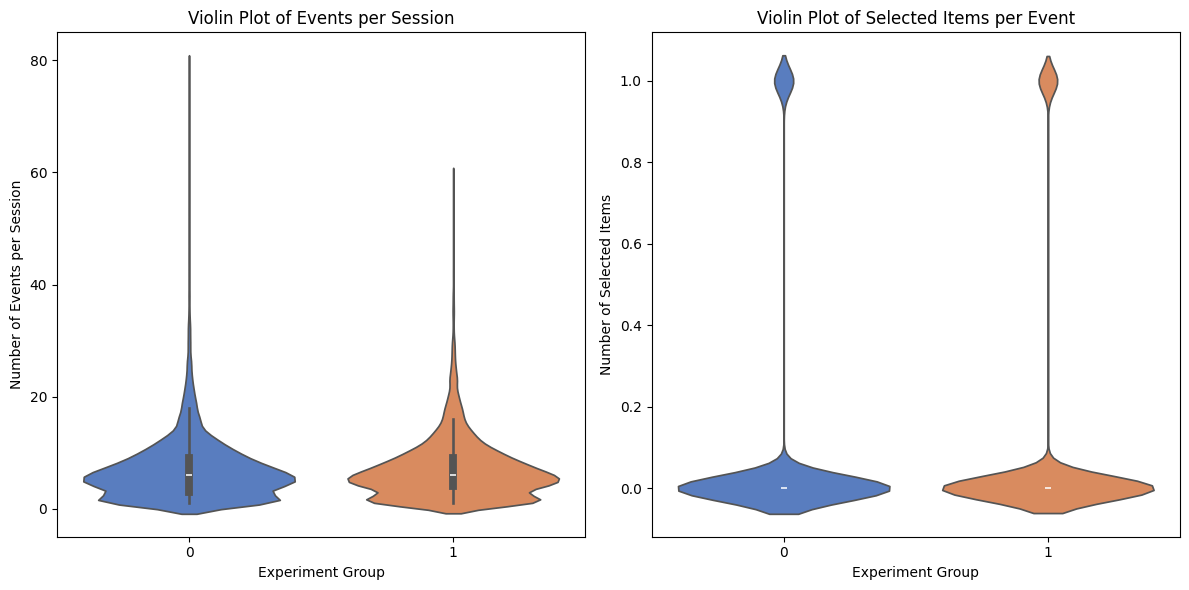

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='experiment_group', y='event_count', data=session_event_counts, palette="muted")
plt.title('Violin Plot of Events per Session')
plt.xlabel('Experiment Group')
plt.ylabel('Number of Events per Session')

plt.subplot(1, 2, 2)
sns.violinplot(x='experiment_group', y='selected_count', data=df_cleaned, palette="muted")
plt.title('Violin Plot of Selected Items per Event')
plt.xlabel('Experiment Group')
plt.ylabel('Number of Selected Items')

plt.tight_layout()
plt.show()

### Results

1. **Number of events per session**:
   - The average number of events per session for Group 0 is 6.98, while for Group 1, it is 7.01.
   - The standard deviation shows that the distribution of events in each group is similar (5.67 for Group 0 and 5.51 for Group 1).

2. **Number of selected items per event**:
   - The average number of selected items per event for both groups is very low: 0.082 for Group 0 and 0.081 for Group 1.
   - Overall, users from both experimental groups select very few items during interaction with the interface.

3. **Statistical tests**:
   - The T-test for the number of events per session showed a t-statistic of -0.38 and a p-value of 0.703, indicating no statistically significant difference between the groups.
   - The Mann-Whitney test for the number of events also found no significant difference (U-statistic = 29131711.5, p-value = 0.371).
   - The T-test for the number of selected items did not show significant differences (t-statistic = 1.01, p-value = 0.311).
   - Levene's test showed no difference in variance between the groups either for the number of events or the number of selected items (p-values for both tests are above 0.7 and 0.3, respectively).

**Conclusion**: The analysis results indicate no statistically significant differences between experimental groups 0 and 1, either in the number of events per session or in the number of selected items. The differences in mean values are very small, and the statistical tests do not confirm the presence of significant effects.